### Notes
2. Remove extreme outlier timestamps for better classification accuracy
3. Handle backspace and delete correctly. Handle it independently of which key was used to delete characters

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyxhook
import time

current_milli_time = lambda: int(round(time.time() * 1000))

In [2]:
number_of_samples = 50
number_of_keys = 8

In [3]:
def get_consecutive_diff(input_arr):
    temp = []
    for x in range(0, len(input_arr)-1):
        temp.append(input_arr[x+1] - input_arr[x])
    return temp
    
def get_arr_diff(down_events, up_events):
    assert len(down_events) == len(up_events)
    temp = []
    for x in range(0, len(down_events)):
        temp.append(up_events[x]-down_events[x])
    return temp

def parse_data(data):
    up_arr = [x[1] for x in data['key_up_events']]
    down_arr = [x[1] for x in data['key_down_events']]
    
    # strip out the last few keys
    up_arr = up_arr[0:number_of_keys]
    down_arr = down_arr[0:number_of_keys]
    
    assert len(up_arr) == len(down_arr) == number_of_keys
    
    up_up_arr = get_consecutive_diff(up_arr)
    down_down_arr = get_consecutive_diff(down_arr)
    down_up_arr = get_arr_diff(down_arr, up_arr)
    
    return (up_up_arr, down_down_arr, down_up_arr)

def get_data(sample_number):   
    f = 'samples/sample_' + str(sample_number) + '.pickle'
    data = pickle.load(open(f,'rb'))
    return parse_data(data)
    
def sample_dist(sample_val, mean, std_dev):
    return (sample_val - mean)/float(std_dev)

## Reading Data

In [4]:
mean_list = []
std_dev_list = []

up_up_data = []
down_down_data = []
down_up_data = []

for i in range(1, number_of_samples+1):
    (up_up_arr, down_down_arr, down_up_arr) = get_data(i)
    up_up_data.append(up_up_arr)
    down_down_data.append(down_down_arr)
    down_up_data.append(down_up_arr)

## Calculating Statistics

In [5]:
up_up_mean_list = []
up_up_std_dev_list = []

df = pd.DataFrame(up_up_data, 
                  index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                  columns=['key_' + str(x) for x in range(1, number_of_keys)])
for key in list(df.columns.values):
    up_up_mean_list.append(np.mean(df[key]))
    up_up_std_dev_list.append(np.std(df[key]))
    
df

,key_1,key_2,key_3,key_4,key_5,key_6,key_7
sample_1,47,154,135,185,111,57,183
sample_2,40,144,144,209,95,48,169
sample_3,37,178,153,191,112,64,176
sample_4,72,192,153,223,89,79,192
sample_5,56,152,136,169,111,49,159
sample_6,48,160,161,207,49,120,191
sample_7,55,176,144,329,127,72,192
sample_8,47,169,143,313,167,48,201
sample_9,48,160,144,185,615,72,200
sample_10,30,161,120,209,111,40,264


In [6]:
down_down_mean_list = []
down_down_std_dev_list = []

df = pd.DataFrame(down_down_data, 
                  index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                  columns=['key_' + str(x) for x in range(1, number_of_keys)])
for key in list(df.columns.values):
    down_down_mean_list.append(np.mean(df[key]))
    down_down_std_dev_list.append(np.std(df[key]))
df

,key_1,key_2,key_3,key_4,key_5,key_6,key_7
sample_1,121,159,120,168,96,93,139
sample_2,88,184,112,168,101,67,168
sample_3,113,159,152,168,104,89,151
sample_4,89,199,144,176,120,93,155
sample_5,100,156,136,160,80,64,160
sample_6,112,152,152,177,71,104,183
sample_7,113,167,160,296,120,93,155
sample_8,108,180,120,312,144,64,169
sample_9,89,151,152,168,592,89,175
sample_10,80,145,111,200,144,24,232


In [7]:
down_up_mean_list = []
down_up_std_dev_list = []

df = pd.DataFrame(down_up_data, 
                  index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                  columns=['key_' + str(x) for x in range(1, number_of_keys+1)]) # since down_up data has one extra 
for key in list(df.columns.values):
    down_up_mean_list.append(np.mean(df[key]))
    down_up_std_dev_list.append(np.std(df[key]))
df

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8
sample_1,119,45,40,55,72,87,51,95
sample_2,111,63,23,55,96,90,71,72
sample_3,112,36,55,56,79,87,62,87
sample_4,87,70,63,72,119,88,74,111
sample_5,95,51,47,47,56,87,72,71
sample_6,111,47,55,64,94,72,88,96
sample_7,112,54,63,47,80,87,66,103
sample_8,104,43,32,55,56,79,63,95
sample_9,87,46,55,47,64,87,70,95
sample_10,112,62,78,87,96,63,79,111


## Validating a Single Outside Sample

In [8]:
def get_scores(up_up_sample, down_down_sample, down_up_sample):
    
    up_up_score = 0
    down_down_score = 0
    down_up_score = 0

    for i in range(0, len(up_up_sample)):
        up_up_score = up_up_score + sample_dist(up_up_sample[i], up_up_mean_list[i], up_up_std_dev_list[i])
    
    for i in range(0, len(down_down_sample)):
        down_down_score = down_down_score + sample_dist(down_down_sample[i], down_down_mean_list[i], down_down_std_dev_list[i])
    
    for i in range(0, len(down_up_sample)):
        down_up_score = down_up_score + sample_dist(down_up_sample[i], down_up_mean_list[i], down_up_std_dev_list[i])
    
    up_up_score = up_up_score/number_of_samples
    down_down_score = down_down_score/number_of_samples
    down_up_score = down_up_score/number_of_samples
    
    return (up_up_score, down_down_score, down_up_score)    

In [9]:
up_up_valid_scores = []
down_down_valid_scores = []
down_up_valid_scores = []

for  i in range(0, number_of_samples):

    (up_up_sample, down_down_sample, down_up_sample) = get_data(i)
    (up_up_score, down_down_score, down_up_score) = get_scores(up_up_sample, down_down_sample,down_up_sample)

    #print 'Up up score:', up_up_score
    #print 'Down down score:', down_down_score
    #print 'Down up score:', down_up_score
    #print ''
    
    up_up_valid_scores.append(up_up_score)
    down_down_valid_scores.append(down_down_score)
    down_up_valid_scores.append(down_up_score)

In [10]:
maximum_number_of_std_deviations_from_mean = 3

up_up_threshold = np.mean(up_up_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(up_up_valid_scores)
down_down_threshold = np.mean(down_down_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(down_down_valid_scores)
down_up_threshold = np.mean(down_up_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(down_up_valid_scores)

print 'Up up threshold:', up_up_threshold
print 'Down Down threshold:', down_down_threshold
print 'Down Up threshold:', down_up_threshold

Up up threshold: 0.180971625901
Down Down threshold: 0.175086203011
Down Up threshold: 0.232105470778


## Validating Live Sample from Local Computer

In [13]:
hookman = pyxhook.HookManager()

curr_str = []
up_events = []
down_events = []
times = 50

def record_event(event, prefix):
    global curr_str
    
    if event.Key == 'BackSpace' and prefix == 'KeyUp:':
        curr_str.pop()
        up_events.pop()
        down_events.pop()
        return
    if not event.Ascii >= 48 and event.Ascii <= 57 and \
       not event.Ascii >= 65 and event.Ascii <= 90 and \
       not event.Ascii >= 97 and event.Ascii <= 122:
        return
    
    if prefix == 'KeyDown:':
        down_events.append([event.Key, current_milli_time()])
    elif prefix == 'KeyUp:':
        up_events.append([event.Key, current_milli_time()])
        curr_str.append(event.Key)
        
def kb_down_event(event):
    record_event(event, 'KeyDown:')

def kb_up_event(event):
    record_event(event, 'KeyUp:')

    if event.Ascii == 32:
        global sample_number
        global curr_str
        global up_events
        global down_events
        global times

        if ''.join(curr_str) == 'password':
            data = dict()
            data['key_down_events'] = down_events
            data['key_up_events'] = up_events
            (up_up_arr, down_down_arr, down_up_arr) = parse_data(data)
            (up_up_score, down_down_score, down_up_score) = get_scores(up_up_arr, down_down_arr, down_up_arr)
            
            print 'Up up score:', up_up_score
            print 'Down down score:', down_down_score
            print 'Down up score:', down_up_score
            
            if up_up_score <= up_up_threshold and down_down_score <= down_down_threshold and down_up_score <= down_up_threshold:
                print 'True'
            else:
                print 'False'
                
            print ''
                
            times = times-1
            if times <= 0:              
                hookman.cancel()
                
        else:
            print 'Incorrect string. Skipping...'
            print curr_str
            
        # clear all variables after space
        curr_str = []
        up_events = []
        down_events = []

hookman.KeyDown = kb_down_event
hookman.KeyUp = kb_up_event

hookman.HookKeyboard()
hookman.start()

RECORD extension version 1.13
Up up score: -0.0416729852511
Down down score: -0.0516761064599
Down up score: 0.0645998239206
True

Up up score: 0.171908763677
Down down score: 0.138076629217
Down up score: 0.16190158934
True

Up up score: 0.10497401664
Down down score: 0.11641762616
Down up score: 0.137937584571
True

Up up score: -0.0129498344245
Down down score: -0.0380157902129
Down up score: 0.187387578475
True

Up up score: 0.0930268478802
Down down score: 0.0941645428005
Down up score: 0.399165685724
False

Up up score: -0.0232174267822
Down down score: -0.0122574331248
Down up score: 0.217674873218
True

Up up score: -0.0565181800304
Down down score: -0.0146840331811
Down up score: 0.101663369924
True

Up up score: 0.19576331576
Down down score: 0.182059404098
Down up score: 0.251866540345
False

Up up score: -0.00585354619757
Down down score: -0.0137528187438
Down up score: 0.0949598899753
True

Up up score: -0.0150340968627
Down down score: -0.0023946914905
Down up score: 0.15

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "pyxhook.py", line 112, in run
    self.record_dpy.record_enable_context(self.ctx, self.processevents)
  File "/usr/lib/python2.7/dist-packages/Xlib/ext/record.py", line 238, in enable_context
    context = context)
  File "/usr/lib/python2.7/dist-packages/Xlib/ext/record.py", line 215, in __init__
    rq.ReplyRequest.__init__(self, *args, **keys)
  File "/usr/lib/python2.7/dist-packages/Xlib/protocol/rq.py", line 1478, in __init__
    self.reply()
  File "/usr/lib/python2.7/dist-packages/Xlib/protocol/rq.py", line 1490, in reply
    self._display.send_and_recv(request = self._serial)
  File "/usr/lib/python2.7/dist-packages/Xlib/protocol/display.py", line 556, in send_and_recv
    gotreq = self.parse_response(request)
  File "/usr/lib/python2.7/dist-packages/Xlib/protocol/display.py", line 643, in parse_response
    gotreq = se

## Potential Bugs
1. Backspace
2. Go to middle, delete key and retype
3. Type half the password, wait a long while. Type the other half.

## Solutions
1. When backspace or any other text modification method is used, solution is to to use a simpler classifier trained on down-up scores. This will reduce complexity at the expense of some accuracy

## Reading and Evaluating Amazon Mechanical Turk Samples

In [14]:
up_up_intruder_scores = []
down_down_intruder_scores = []
down_up_intruder_scores = []

data = pd.read_csv('live_samples/keyboard_events.csv')
for idx, row in data.iterrows():
    up_events_str = row['up_events']
    down_events_str = row['down_events']
    
    up_arr = [int(x) for x in up_events_str.split(',')]
    down_arr = [int(x) for x in down_events_str.split(',')]
    
    up_up_arr = get_consecutive_diff(up_arr)
    down_down_arr = get_consecutive_diff(down_arr)
    down_up_arr = get_arr_diff(down_arr, up_arr)
    
    (up_up_score, down_down_score, down_up_score) = get_scores(up_up_arr, down_down_arr, down_up_arr)
    
    #print 'Up up score:', up_up_score
    #print 'Down down score:', down_down_score
    #print 'Down up score:', down_up_score
    #print ''
    
    up_up_intruder_scores.append(up_up_score)
    down_down_intruder_scores.append(down_down_score)
    down_up_intruder_scores.append(down_up_score)
    

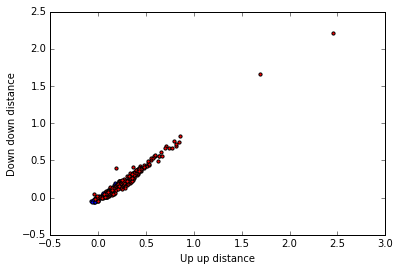

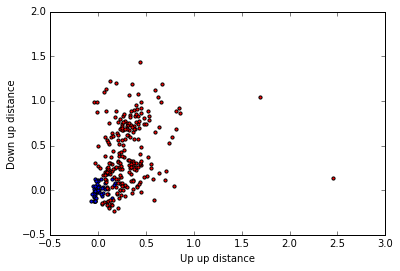

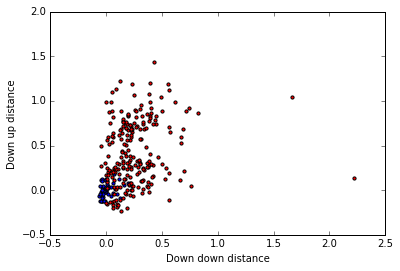

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(up_up_valid_scores, down_down_valid_scores, s=10, c='b', marker="o", label='valid')
ax1.scatter(up_up_intruder_scores, down_down_intruder_scores, s=10, c='r', marker="o", label='intruder')
plt.xlabel('Up up distance')
plt.ylabel('Down down distance')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.scatter(up_up_valid_scores, down_up_valid_scores, s=10, c='b', marker="o", label='valid')
ax2.scatter(up_up_intruder_scores, down_up_intruder_scores, s=10, c='r', marker="o", label='intruder')
plt.xlabel('Up up distance')
plt.ylabel('Down up distance')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(111)
ax3.scatter(down_down_valid_scores, down_up_valid_scores, s=10, c='b', marker="o", label='valid')
ax3.scatter(down_down_intruder_scores, down_up_intruder_scores, s=10, c='r', marker="o", label='intruder')
plt.xlabel('Down down distance')
plt.ylabel('Down up distance')
plt.show()

## Reading and Evaluating Amazon Mechanical Turk Samples with SVM

In [200]:
up_up_data = up_up_valid_scores + up_up_intruder_scores
down_down_data = down_down_valid_scores + down_down_intruder_scores
down_up_data = down_up_valid_scores + down_up_intruder_scores

h = .01 # step size in the mesh
C = 5  # SVM regularization parameter
gamma = 1 # SVM gamma
weight_offset = 0.2

(-1.0605270162911473, 3.2094729837088565)

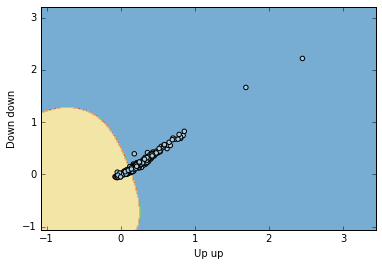

In [201]:
X = np.array((up_up_data, down_down_data)).transpose()
y = list(np.ones(len(up_up_valid_scores))) + list(np.zeros(len(up_up_intruder_scores)))

sample_weights = [q + weight_offset for q in y]
svc = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X, y, sample_weight=sample_weights)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Up up')
plt.ylabel('Down down')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.2371586984346152, 2.4228413015653878)

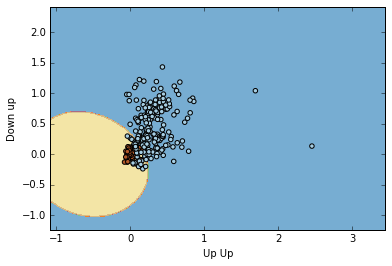

In [202]:
X = np.array((up_up_data, down_up_data)).transpose()
y = list(np.ones(len(up_up_valid_scores))) + list(np.zeros(len(up_up_intruder_scores)))

sample_weights = [q + weight_offset for q in y]
svc = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X, y, sample_weight=sample_weights)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Up Up')
plt.ylabel('Down up')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.2371586984346152, 2.4228413015653878)

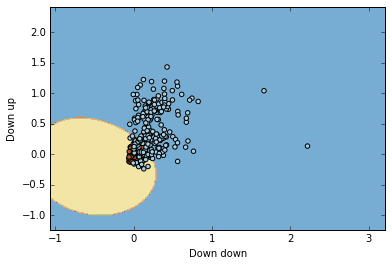

In [203]:
X = np.array((down_down_data, down_up_data)).transpose()
y = list(np.ones(len(down_down_valid_scores))) + list(np.zeros(len(down_down_intruder_scores)))

sample_weights = [q + weight_offset for q in y]
svc = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X, y, sample_weight=sample_weights)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Down down')
plt.ylabel('Down up')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## Combined SVM

In [206]:
up_up_data = up_up_valid_scores + up_up_intruder_scores
down_down_data = down_down_valid_scores + down_down_intruder_scores
down_up_data = down_up_valid_scores + down_up_intruder_scores

h = .01 # step size in the mesh
C = 5  # SVM regularization parameter
gamma = 1 # SVM gamma
weight_offset = 0.2

In [213]:
X = np.array((up_up_data, down_down_data, down_up_data)).transpose()
y = list(np.ones(len(up_up_valid_scores))) + list(np.zeros(len(up_up_intruder_scores)))

sample_weights = [q + weight_offset for q in y]
svc = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X, y, sample_weight=sample_weights)

In [220]:
hookman = pyxhook.HookManager()

curr_str = []
up_events = []
down_events = []
times = 50

def record_event(event, prefix):
    global curr_str
    
    if event.Key == 'BackSpace' and prefix == 'KeyUp:':
        curr_str.pop()
        up_events.pop()
        down_events.pop()
        return
    if not event.Ascii >= 48 and event.Ascii <= 57 and \
       not event.Ascii >= 65 and event.Ascii <= 90 and \
       not event.Ascii >= 97 and event.Ascii <= 122:
        return
    
    if prefix == 'KeyDown:':
        down_events.append([event.Key, current_milli_time()])
    elif prefix == 'KeyUp:':
        up_events.append([event.Key, current_milli_time()])
        curr_str.append(event.Key)
        
def kb_down_event(event):
    record_event(event, 'KeyDown:')

def kb_up_event(event):
    record_event(event, 'KeyUp:')

    if event.Ascii == 32:
        global sample_number
        global curr_str
        global up_events
        global down_events
        global times

        if ''.join(curr_str) == 'password':
            data = dict()
            data['key_down_events'] = down_events
            data['key_up_events'] = up_events
            (up_up_arr, down_down_arr, down_up_arr) = parse_data(data)
            (up_up_score, down_down_score, down_up_score) = get_scores(up_up_arr, down_down_arr, down_up_arr)
            
            print 'Up up score:', up_up_score
            print 'Down down score:', down_down_score
            print 'Down up score:', down_up_score
            
            datapoint = np.array((up_up_score, down_down_score, down_up_score)).reshape(1, -1)
            print svc.predict(datapoint)
                
            times = times-1
            if times <= 0:              
                hookman.cancel()
                
        else:
            print 'Incorrect string. Skipping...'
            print curr_str
            
        # clear all variables after space
        curr_str = []
        up_events = []
        down_events = []

hookman.KeyDown = kb_down_event
hookman.KeyUp = kb_up_event

hookman.HookKeyboard()
hookman.start()

RECORD extension version 1.13
Incorrect string. Skipping...
['p', 'p', 'a', 'a', 's', 's', 's', 's', 'w', 'w', 'o', 'o', 'r', 'r', 'd', 'd']
Incorrect string. Skipping...
[]
Incorrect string. Skipping...
['p', 'p', 'a', 'a', 's', 's', 's', 's', 'w', 'w', 'o', 'o', 'r', 'r', 'd', 'd']
Incorrect string. Skipping...
[]
Incorrect string. Skipping...
['p', 'p', 'a', 'a', 's', 's', 's', 's', 'w', 'w', 'o', 'o', 'r', 'r', 'd', 'd']
Incorrect string. Skipping...
[]
Incorrect string. Skipping...Incorrect string. Skipping...

['p', 'p', 'a', 'a', 's', 's', 's', 's', 'w', 'w', 'o', 'o', 'r', 'r', 'd', 'd']['p', 'p', 'a', 'a', 's', 's', 's', 's', 'w', 'w', 'o', 'o', 'r', 'r', 'd', 'd']

Incorrect string. Skipping...
['p', 'p', 'a', 'a', 's', 's', 's', 's', 'w', 'w', 'o', 'o', 'r', 'r', 'd', 'd']
Incorrect string. Skipping...
[]
Incorrect string. Skipping...
['p', 'p', 'a', 'a', 's', 's', 's', 's', 'w', 'w', 'o', 'o', 'r', 'r', 'd', 'd']
Incorrect string. Skipping...
[]
Incorrect string. Skipping..